In [1]:
import rasterio
import numpy as np
import os

# Direktori kerja
data_dir = r'd:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/'

# File input
eigen_file = os.path.join(data_dir, 'Eigenvector_PCA_PC1_AllMonths_1981_2024_clipped.tif')
chirps_file = os.path.join(data_dir, '01_chirps22_aoi.tif')

# File output
norm_eigen_out = os.path.join(data_dir, 'norm_eigen.tif')
norm_chirps_out = os.path.join(data_dir, 'norm_chirps.tif')

def normalize_and_save(input_file, output_file):
    with rasterio.open(input_file) as src:
        data = src.read(1).astype(float)
        profile = src.profile
        nodata = profile.get('nodata', np.nan)

        # Buat mask gabungan untuk nodata dan NaN
        mask = np.isnan(data)
        if nodata is not None and not np.isnan(nodata):
            mask |= (data == nodata)

        # Normalisasi hanya pada nilai valid
        valid_data = data[~mask]
        min_val, max_val = np.min(valid_data), np.max(valid_data)

        norm_data = np.full_like(data, np.nan, dtype='float32')
        if max_val == min_val:
            norm_data[~mask] = 1.0  # semua nilai sama → skala penuh
        else:
            norm_data[~mask] = (valid_data - min_val) / (max_val - min_val)

        # Update metadata dan tulis raster
        profile.update(dtype=rasterio.float32, nodata=np.nan)
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(norm_data, 1)

# Eksekusi normalisasi
normalize_and_save(eigen_file, norm_eigen_out)
normalize_and_save(chirps_file, norm_chirps_out)

print("✅ Normalisasi selesai. File disimpan:")
print(f"- {norm_eigen_out}")
print(f"- {norm_chirps_out}")

✅ Normalisasi selesai. File disimpan:
- d:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/norm_eigen.tif
- d:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/norm_chirps.tif


**Penentuan Bobot EigenValue dan Curah Hujan dengan Uji Sensitivitas**

In [2]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np

# Path input dan output
chirps_path = 'D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/norm_chirps.tif'
eigen_path = 'D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/norm_eigen.tif'
resampled_eigen_path = 'D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/norm_eigen_resampled.tif'

# Buka raster referensi (chirps)
with rasterio.open(chirps_path) as ref:
    ref_profile = ref.profile
    ref_array = ref.read(1)
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_shape = ref_array.shape

# Buka eigen dan lakukan resampling
with rasterio.open(eigen_path) as src:
    eigen_array = src.read(1)
    eigen_profile = src.profile

    resampled_array = np.empty(ref_shape, dtype='float32')

    reproject(
        source=eigen_array,
        destination=resampled_array,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        resampling=Resampling.bilinear
    )

# Simpan hasil resampling
resampled_profile = ref_profile.copy()
resampled_profile.update(dtype='float32')

with rasterio.open(resampled_eigen_path, 'w', **resampled_profile) as dst:
    dst.write(resampled_array, 1)

print("✅ norm_eigen.tif berhasil di-resample dan disimpan sebagai:")
print(resampled_eigen_path)

✅ norm_eigen.tif berhasil di-resample dan disimpan sebagai:
D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/norm_eigen_resampled.tif


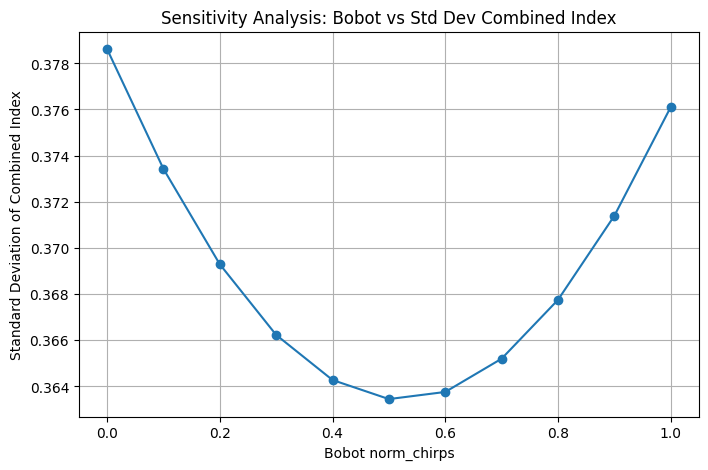

📌 Bobot optimal berdasarkan std dev tertinggi:
- norm_chirps: 0.0
- norm_eigen : 1.0
- Std Dev    : 0.3786


In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File raster
norm_chirps_path = 'D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/norm_chirps.tif'
norm_eigen_path = 'D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/norm_eigen_resampled.tif'

# Baca raster
with rasterio.open(norm_chirps_path) as chirps_src:
    chirps = chirps_src.read(1).astype('float32')
    nodata = chirps_src.nodata

with rasterio.open(norm_eigen_path) as eigen_src:
    eigen = eigen_src.read(1).astype('float32')

# Buat mask NoData
mask = np.isnan(chirps)
if nodata is not None and not np.isnan(nodata):
    mask |= (chirps == nodata)

mask |= np.isnan(eigen)

# Siapkan list bobot dan hasil statistik
weights = np.arange(0.0, 1.1, 0.1)  # w_chirps dari 0.0 sampai 1.0
std_devs = []

# Lakukan kombinasi dan hitung statistik (misal: std)
for w_chirps in weights:
    w_eigen = 1 - w_chirps
    combined = w_chirps * chirps + w_eigen * eigen
    combined[mask] = np.nan
    std_val = np.nanstd(combined)  # Bisa diganti metrik lain sesuai konteks
    std_devs.append(std_val)

# Visualisasi hasil
plt.figure(figsize=(8, 5))
plt.plot(weights, std_devs, marker='o')
plt.title("Sensitivity Analysis: Bobot vs Std Dev Combined Index")
plt.xlabel("Bobot norm_chirps")
plt.ylabel("Standard Deviation of Combined Index")
plt.grid(True)
plt.show()

# Tampilkan kombinasi bobot terbaik (contoh: nilai std terbesar)
best_idx = np.argmax(std_devs)
print("📌 Bobot optimal berdasarkan std dev tertinggi:")
print(f"- norm_chirps: {weights[best_idx]:.1f}")
print(f"- norm_eigen : {1 - weights[best_idx]:.1f}")
print(f"- Std Dev    : {std_devs[best_idx]:.4f}")

Meskipun hasil uji sensitivitas, bobot optimal (berdasarkan std dev tertinggi):
- norm_chirps: 0.0
- norm_eigen : 1.0

karena komponen norm_eigen (stabilitas pola curah hujan dari PCA) memiliki keragaman spasial yang lebih tinggi, dan lebih mampu membedakan antar grid dibandingkan norm_chirps (kuantitas curah hujan aktual). Namun, dari sisi kepraktisan hidrologi, Anda mungkin tetap ingin memberi bobot tertentu pada curah hujan aktual karena itu menunjukkan potensi air aktual.

Secara ilmu lingkungan atau manajemen sumber daya air, Anda bisa pertimbangkan kompromi seperti:
- norm_chirps: 0.3
- norm_eigen : 0.7

In [4]:
import rasterio
import numpy as np
import os

# Path raster input
data_dir = r'D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/'
chirps_path = os.path.join(data_dir, 'norm_chirps.tif')
eigen_path = os.path.join(data_dir, 'norm_eigen_resampled.tif')  # Pastikan sudah disamakan ukuran

# Output
output_path = os.path.join(data_dir, 'combinedidx_rainfall.tif')

# Bobot
w_chirps = 0.3
w_eigen = 0.7

# Baca raster
with rasterio.open(chirps_path) as chirps_src, rasterio.open(eigen_path) as eigen_src:
    chirps = chirps_src.read(1).astype('float32')
    eigen = eigen_src.read(1).astype('float32')
    meta = chirps_src.meta.copy()
    nodata = chirps_src.nodata

# Buat mask nodata
mask = np.isnan(chirps) | np.isnan(eigen)
if nodata is not None and not np.isnan(nodata):
    mask |= (chirps == nodata) | (eigen == nodata)

# Hitung indeks gabungan
combined = np.full_like(chirps, np.nan, dtype='float32')
combined[~mask] = w_chirps * chirps[~mask] + w_eigen * eigen[~mask]

# Update metadata output
meta.update(dtype='float32', nodata=np.nan)

# Simpan raster hasil gabungan
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(combined, 1)

print("✅ Combined index selesai dihitung dan disimpan sebagai:")
print(output_path)

✅ Combined index selesai dihitung dan disimpan sebagai:
D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/combinedidx_rainfall.tif


**Hitung skor kriteria HUJAN**

In [5]:
import rasterio
import numpy as np
import os

# Path input/output
data_dir = r'D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/'
input_path = os.path.join(data_dir, 'combinedidx_rainfall.tif')
output_path = os.path.join(data_dir, 'combinedidx_score.tif')

# Baca raster
with rasterio.open(input_path) as src:
    combined = src.read(1).astype('float32')
    profile = src.profile
    nodata = src.nodata

# Buat mask
mask = np.isnan(combined)
if nodata is not None and not np.isnan(nodata):
    mask |= (combined == nodata)

# Skoring 5 kelas berdasarkan quantile
valid = combined[~mask]
q = np.quantile(valid, [0, 0.2, 0.4, 0.6, 0.8, 1.0])  # 5 kelas

# Fungsi skoring
def classify(val):
    if np.isnan(val):
        return np.nan
    elif val <= q[1]:
        return 1
    elif val <= q[2]:
        return 2
    elif val <= q[3]:
        return 3
    elif val <= q[4]:
        return 4
    else:
        return 5

vectorized_classify = np.vectorize(classify)
score_raster = vectorized_classify(combined).astype('float32')

# Simpan skor
profile.update(dtype='float32', nodata=np.nan)
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(score_raster, 1)

print("✅ Skoring selesai. Hasil disimpan di:")
print(output_path)

✅ Skoring selesai. Hasil disimpan di:
D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/combinedidx_score.tif


**Join Skor Hujan ke dalam GRID 30"**

In [ ]:
# pip install rasterstats


   ---------------------------------------- 0/2 [simplejson]
   ---------------------------------------- 0/2 [simplejson]
   ---------------------------------------- 0/2 [simplejson]
   ---------------------------------------- 0/2 [simplejson]
   -------------------- ------------------- 1/2 [rasterstats]
   ---------------------------------------- 2/2 [rasterstats]

Note: you may need to restart the kernel to use updated packages.


In [4]:
from rasterstats import zonal_stats
import geopandas as gpd
import os

# Path
data_dir = r'D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/'
shp_path = os.path.join(data_dir, 'grid30_par_combidx.shp')
score_raster_path = os.path.join(data_dir, 'combinedidx_score.tif')
output_shp_path = os.path.join(data_dir, 'grid30_raineigen.shp')

# Hitung zonal statistics: mean score
stats = zonal_stats(shp_path, score_raster_path, stats="majority", geojson_out=True)

# Gabungkan ke GeoDataFrame
gdf = gpd.read_file(shp_path)
# gdf['skor_rain'] = [feat['properties']['majority'] for feat in stats]
gdf['skor_rain'] = [int(feat['properties']['majority']) for feat in stats]

# Simpan shapefile baru
gdf.to_file(output_shp_path)

print("✅ Zonal join selesai. Hasil disimpan di:")
print(output_shp_path)

✅ Zonal join selesai. Hasil disimpan di:
D:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/grid30_raineigen.shp


**Hitung MCDA**

In [5]:
import geopandas as gpd

# Load shapefile hasil sebelumnya
gdf = gpd.read_file("d:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/grid30_raineigen.shp")

# Fungsi scoring
def score_twi(val):
    if val < 0: return 1
    elif val <= 5: return 2
    elif val <= 10: return 3
    elif val <= 15: return 4
    else: return 5

# Peta scoring
pl22_scores = {
    'Badan air': 1, 'Hutan': 4, 'Kawasan lindung/konservasi': 4,
    'Lahan terbangun': 2, 'Padang rumput': 3, 'Perkebunan': 4,
    'Pertanian lahan basah': 5, 'Pertanian lahan kering': 3, 'Tambak': 1
}

tanah_scores = {
    'Aluvial': 5, 'Andosol': 3, 'Gleisol': 5, 'Grumusol': 5,
    'Kambisol': 4, 'Litosol': 2, 'Mediteran': 3, 'Podsolik': 3,
    'Regosol': 2, 'Lain-lain': 3
}

# Terapkan fungsi scoring (format integer)
gdf['skor_twi'] = gdf['twi'].apply(score_twi).astype(int)
gdf['skor_lahan'] = gdf['pl22'].map(pl22_scores).fillna(3).astype(int)
gdf['skor_tanah'] = gdf['tanah'].map(tanah_scores).fillna(3).astype(int)

# Hitung skor MCDA akhir (float)
gdf['mcda_score'] = (
    0.30 * gdf['skor_rain'] +
    0.30 * gdf['skor_twi'] +
    0.20 * gdf['skor_lahan'] +
    0.20 * gdf['skor_tanah']
)

# Klasifikasi MCDA
def klasifikasi_mcda(val):
    if val < 2.5: return 'Tidak sesuai'
    elif val < 3.5: return 'Cukup sesuai'
    elif val < 4.5: return 'Sesuai'
    else: return 'Sangat sesuai'

gdf['kelas_mcda'] = gdf['mcda_score'].apply(klasifikasi_mcda)

# Simpan shapefile hasil akhir
output_path = "d:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/grid30_mcda_rev.shp"
gdf.to_file(output_path)

print("✅ Skor MCDA berhasil dihitung dan disimpan sebagai:", output_path)

✅ Skor MCDA berhasil dihitung dan disimpan sebagai: d:/GeospatialData/01_EMBUNG JABAR/ISeNREM/revisi/grid30_mcda_rev.shp
